In [1]:
%pip install pandas numpy rapidfuzz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
import os
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import networkx as nx

In [3]:

# STEP 1: LOAD DATA

input_filename = 'health_registry.csv'

# Check if file exists before trying to load it
if os.path.exists(input_filename):
    df = pd.read_csv(input_filename)
    print(f"✅ Success! Loaded {len(df)} rows.")
else:
    print("❌ Error: File not found.")
    raise FileNotFoundError("Input file missing. Please check the file path.")

✅ Success! Loaded 13013 rows.


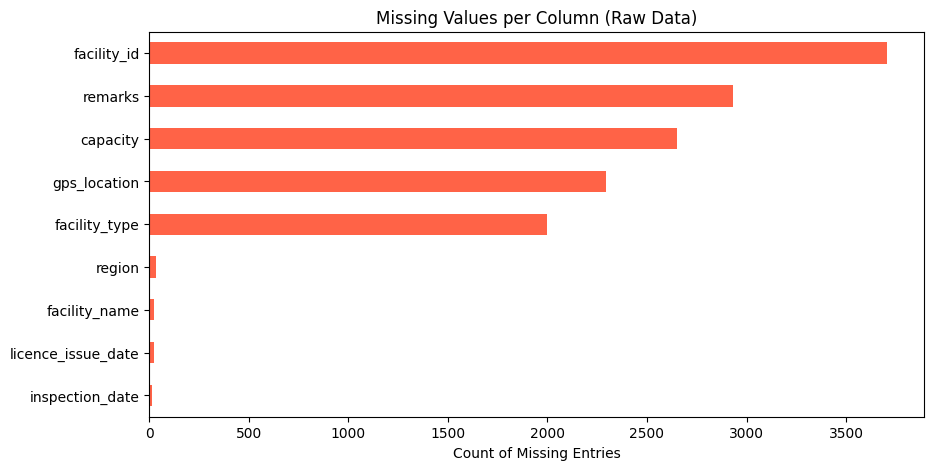

In [4]:
# EDA STEP 1: Visualize Missing Data
import matplotlib.pyplot as plt

# Calculate missing percentages
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

# Plot
plt.figure(figsize=(10, 5))
missing.plot(kind='barh', color='tomato')
plt.title("Missing Values per Column (Raw Data)")
plt.xlabel("Count of Missing Entries")
plt.show()

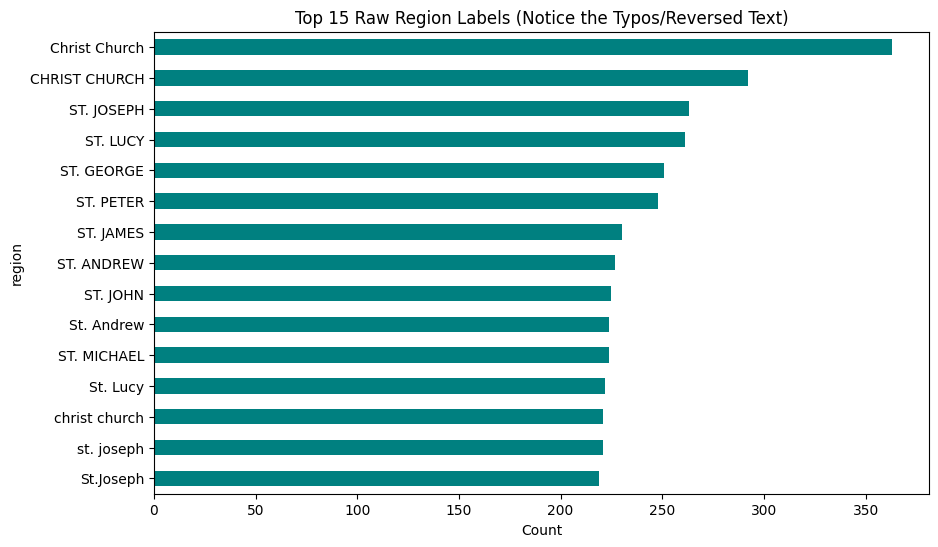

In [5]:
# EDA STEP 2: The "Dirty" Region Labels
# Show the top 15 most common region labels to highlight the mess
top_regions = df['region'].value_counts().head(15)

plt.figure(figsize=(10, 6))
top_regions.plot(kind='barh', color='teal')
plt.title("Top 15 Raw Region Labels (Notice the Typos/Reversed Text)")
plt.xlabel("Count")
plt.gca().invert_yaxis() # Put the biggest on top
plt.show()

In [6]:
import pandas as pd
import numpy as np
import re
import os
from rapidfuzz import process, fuzz


# STEP 1: LOAD DATA

input_filename = 'health_registry.csv'
output_filename = 'cleaned_health_registry.csv'

print(f"Looking for file: {input_filename}...")

if os.path.exists(input_filename):
    df = pd.read_csv(input_filename)
    print(f"✅ Success! Loaded {len(df)} rows.")
else:
    print("❌ Error: File not found.")
    raise FileNotFoundError("Input file missing.")


# STEP 2: "NUCLEAR" CLEANING FUNCTIONS


def clean_region(text):
    """Standardizes Parish names and fixes spacing."""
    if pd.isna(text): return "Unknown"
    text = str(text).strip()
    
    # 1. Handle reversed text
    if text.endswith(".tS") or text.endswith(".TS"):
        text = text[::-1]
    
    # 2. Fix Typo Mapping
    corrections = {
        "Christchurch": "Christ Church",
        "Werdna": "St. Andrew",
        "Leahcim": "St. Michael",
        "Nhoj": "St. John",
        "Hpesoj": "St. Joseph",
        "Egroeg": "St. George",
        "Retep": "St. Peter",
        "Semaj": "St. James"
    }
    
    text = text.title()
    for typo, correct in corrections.items():
        if typo in text:
            text = correct
            
    # 3. Standardize "St." formatting
    text = re.sub(r'\bSt\.?\s*', 'St. ', text, flags=re.IGNORECASE)
    
    # 4. Remove "Parish"
    text = text.replace("Parish", "")
    
    # 5. Fix Double Spaces (The "St.  Andrew" fix)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def clean_facility_name(text):
    """
    Aggressively cleans names to remove ghost artifacts.
    """
    if pd.isna(text): return np.nan
    text = str(text)
    
    # 1. Basic cleanup
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove emojis
    text = text.replace('NewLine', '').replace('©', '')
    
    # 2. Remove Reversed/Typo Parish names appearing inside Facility Name
    bad_words = [
        'Werdna', 'Retep', 'Semaj', 'Nhoj', 'Hpesoj', 'Egroeg', 'Leahcim'
    ]
    for word in bad_words:
        text = re.sub(word, '', text, flags=re.IGNORECASE)

    # 3. Remove Standard Parish Names from inside the Facility Name
   
    parishes = [
        r'St\.?\s*James', r'St\.?\s*George', r'St\.?\s*Peter', r'St\.?\s*Lucy',
        r'St\.?\s*Andrew', r'St\.?\s*Joseph', r'St\.?\s*John', r'St\.?\s*Michael',
        r'Christ\s*Church', r'St\.?\s*Thomas', r'St\.?\s*Philip',
        r'\(St\.?\)', r'\(Christ\)'
    ]
    for p in parishes:
        text = re.sub(p, '', text, flags=re.IGNORECASE)

   
    
    # 4. Remove Empty Brackets "()" or "( )" or "(   )"
    text = re.sub(r'\(\s*\)', '', text)

    # 5. Remove dangling "St" at the end (with optional punctuation)
    # Matches "Clinic St", "Clinic St.", "Clinic St -"
    text = re.sub(r'\bSt\.?[\s\W]*$', '', text, flags=re.IGNORECASE)
    
    # 6. Remove dangling open brackets at end of string
    # Matches "Hospital ("
    text = re.sub(r'\([\s\W]*$', '', text)
    
    # 7. Final Sweep: Remove trailing punctuation and double spaces
    text = text.strip(" ,.-")
    text = re.sub(r'\s+', ' ', text) # Fix double spaces
    
    return text.strip().title()

def clean_capacity(val):
    if pd.isna(val): return np.nan
    val = str(val).lower()
    if 'ten' in val: return 10
    if 'one' in val: return 1
    digits = re.findall(r'\d+', val)
    if digits:
        return int(digits[0])
    return np.nan

def parse_gps(val):
    if pd.isna(val) or val == 'N/A': return None, None
    val = str(val)
    if 'POINT' in val:
        nums = re.findall(r'-?\d+\.\d+', val)
        if len(nums) == 2:
            return float(nums[1]), float(nums[0]) 
    nums = re.findall(r'-?\d+\.\d+', val)
    if len(nums) == 2:
        n1, n2 = float(nums[0]), float(nums[1])
        lat = n1 if 12 < abs(n1) < 14 else n2
        lon = n1 if -60 < n1 < -58 else n2
        return lat, lon
    return np.nan, np.nan

def standardize_type(t):
    if pd.isna(t): return "Unknown"
    t = str(t).lower()
    if 'hosp' in t: return 'Hospital'
    if 'poly' in t: return 'Polyclinic'
    if 'comm' in t or 'chc' in t: return 'Community Health Centre'
    if 'clinic' in t or 'center' in t or 'ctr' in t: return 'Clinic'
    return "Other"


# STEP 3: APPLY CLEANING

print("Processing data cleaning...")

df_clean = df.copy()

df_clean['clean_name'] = df_clean['facility_name'].apply(clean_facility_name)
df_clean['clean_parish'] = df_clean['region'].apply(clean_region)
df_clean['clean_capacity'] = df_clean['capacity'].apply(clean_capacity)
df_clean['clean_type'] = df_clean['facility_type'].apply(standardize_type)


# Remove rows where name is NaN, empty, or just symbols
df_clean = df_clean.dropna(subset=['clean_name'])
df_clean = df_clean[df_clean['clean_name'] != '']
df_clean = df_clean[df_clean['clean_name'].str.contains(r'[a-zA-Z]', na=False)]

# Fix Dates
df_clean['inspection_date'] = pd.to_datetime(df_clean['inspection_date'], dayfirst=True, errors='coerce')
df_clean['licence_issue_date'] = pd.to_datetime(df_clean['licence_issue_date'], dayfirst=True, errors='coerce')

# Parse GPS
df_clean[['lat', 'lon']] = df_clean['gps_location'].apply(lambda x: pd.Series(parse_gps(x)))


# STEP 4: REMOVE DUPLICATES

print("Removing duplicates...")

df_clean = df_clean.sort_values('clean_name')
records = df_clean.to_dict('records')
unique_records = []
seen_identities = [] 

for row in records:
    name = row['clean_name']
    parish = row['clean_parish']
    is_duplicate = False
    
    for seen_name, seen_parish in seen_identities:
        # Match if Parish is same AND name is > 85% similar
        if parish == seen_parish and fuzz.ratio(name, seen_name) > 85:
            is_duplicate = True
            break
    
    if not is_duplicate:
        seen_identities.append((name, parish))
        unique_records.append(row)

final_df = pd.DataFrame(unique_records)

# Ensure ID exists
if 'facility_id' not in final_df.columns:
    final_df['facility_id'] = range(1, len(final_df) + 1)
final_df['facility_id'] = final_df['facility_id'].fillna(pd.Series(range(1, len(final_df) + 1)))

# Select Columns
export_cols = ['facility_id', 'clean_name', 'clean_type', 'clean_parish', 'clean_capacity', 
               'licence_issue_date', 'inspection_date', 'lat', 'lon', 'remarks']
final_df = final_df[export_cols]


# STEP 5: SAVE

final_df.to_csv(output_filename, index=False)

print("\n" + "="*40)
print(f"Cleanup Complete. Saved to {output_filename}")
print(f"Original: {len(df)} -> Final: {len(final_df)}")
print("="*40)
display(final_df.head())

Looking for file: health_registry.csv...
✅ Success! Loaded 13013 rows.
Processing data cleaning...


C:\Users\Oggam\AppData\Local\Temp\ipykernel_33260\1287847446.py:165: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['licence_issue_date'] = pd.to_datetime(df_clean['licence_issue_date'], dayfirst=True, errors='coerce')


Removing duplicates...

Cleanup Complete. Saved to cleaned_health_registry.csv
Original: 13013 -> Final: 9641


,facility_id,clean_name,clean_type,clean_parish,clean_capacity,licence_issue_date,inspection_date,lat,lon,remarks
0,4158,Abbott And Sons,Unknown,St. Andrew,NaN,2019-05-02,NaT,12.88159,-59.05226,Needs upgrade
1,HF-0964,Abbott And Sons,Hospital,St. Joseph,259.0,2023-12-26,NaT,12.90995,-58.96064,NaN
2,3,"Abbott, Lowery And Parrish Medical Center",Polyclinic,St. Joseph,132.0,2019-12-17,NaT,12.73557,-59.00063,♥
3,#4562,"Abbott, Terry And Hendrix Health Centre",Community Health Centre,St. Andrew,NaN,2018-12-25,NaT,12.91290,-59.29663,NaN
4,6903,Abbott-Montgomery Infirmary,Clinic,St. Peter,312.0,2019-09-27,2019-10-03,NaN,NaN,Good


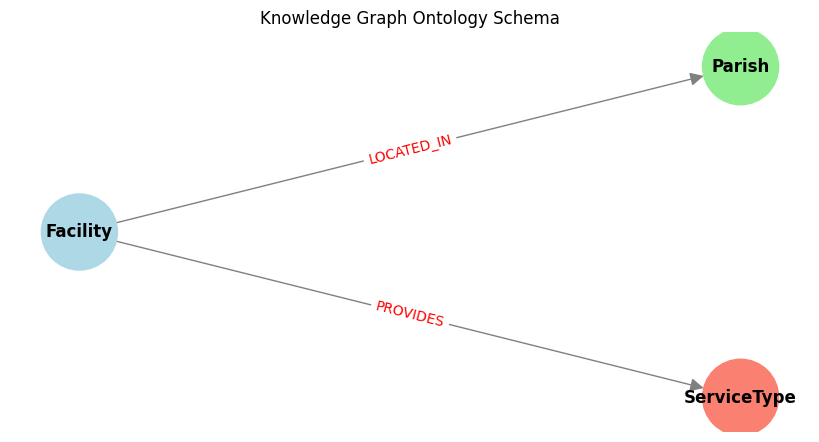

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Create the Graph Object
G = nx.DiGraph()

# 2. Add the Nodes (The "Classes")
G.add_node("Facility", color='lightblue')
G.add_node("Parish", color='lightgreen')
G.add_node("ServiceType", color='salmon')

# 3. Add the Relationships (The "Edges")
G.add_edge("Facility", "Parish", label="LOCATED_IN")
G.add_edge("Facility", "ServiceType", label="PROVIDES")

# 4. Set up the Layout (Positioning)
pos = {
    'Facility': (0, 0),
    'Parish': (1, 0.5),
    'ServiceType': (1, -0.5)
}

# 5. Draw the Graph
plt.figure(figsize=(8, 4))

nx.draw(G, pos, with_labels=True, node_size=3000, 
        node_color=['lightblue', 'lightgreen', 'salmon'], 
        font_weight='bold', edge_color='gray', arrowsize=20)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Knowledge Graph Ontology Schema")
plt.axis('off')
plt.show()